# Make mock IFU datacubes for stellar population and kinematic modelling

Basic demo for how to create a three component galaxy. Full docs coming soon.

## Get SSP templates and an IFU-cube

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import popkinmocks as pkm

In [2]:
ssps = pkm.model_grids.milesSSPs()
cube = pkm.ifu_cube.IFUCube(ssps=ssps, nx1=25, nx2=26, nv=51, vrng=(-1000,1000))

## Create a disk component

Next create a disk component,

In [3]:
disk1 = pkm.components.GrowingDisk(cube=cube, rotation=0., center=(0,0))

### Star formation history

Specify the star formation history of the disk as a beta distribution with mean `0<phi<1` and concentration `lmd`,

<AxesSubplot:xlabel='$t$ [Gyr]'>

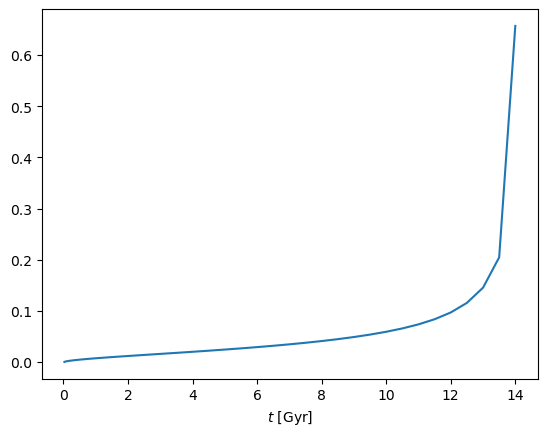

In [4]:
disk1.set_p_t(lmd=2., phi=0.8)
cube.plot('t', disk1.get_p('t'))

### Age-dependent spatial density

Set the age dependent spatial-density. These are cored, flattened power law profiles. Specifically,

$$
p(\vect{x}|t) \propto (r_q + r_c(t))^{-\alpha(t)}
$$

where elliptical radius

$$
r_q^2 = x^2 + \left(\frac{y}{q(t)}\right)^2
$$

and $r_c(t)$ is core length, $\alpha(t)$ is power law slope and $q(t)$ the flattening. All three parameters vary with age, and are specified as pairs of values for (young, old) stars. For intermediate ages the parameter is linearly interpolated.

(25, 26, 53)


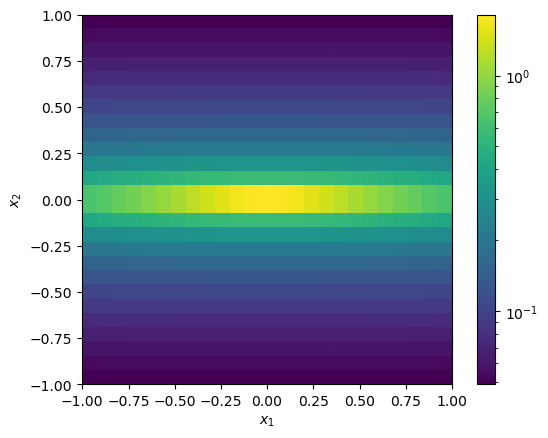

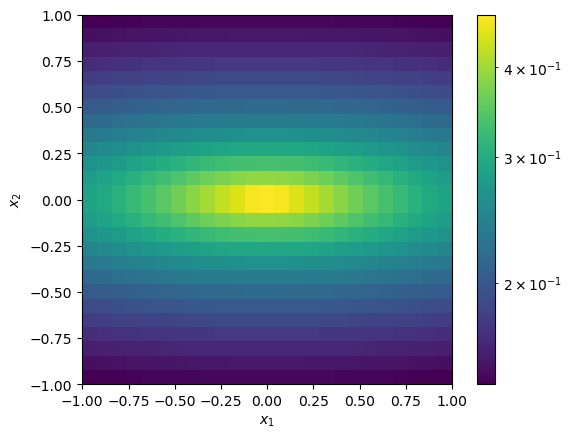

In [5]:
disk1.set_p_x_t(q_lims=(0.1, 0.3),
                rc_lims=(0.1, 0.9),
                alpha_lims=(1.2, 0.8))

p_x_t = disk1.get_p('x_t')
print(p_x_t.shape)

# plot surface density for youngest stars
cube.imshow(p_x_t[:,:,0], norm=LogNorm())
plt.show()

# plot surface density for oldest stars
cube.imshow(p_x_t[:,:,-1], norm=LogNorm())
plt.show()

### Spatially-dependent chemical enrichment

These come from age-metallicity models written down in equations 3-10 of [Zhu et al 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.1579Z/abstract). The models are parameterised by depletion timescale `t_dep`. This parameter stratified on ellipses parameterised by axis ratio `q`, a power law slope `alpha` and an inner and outer values,

<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>

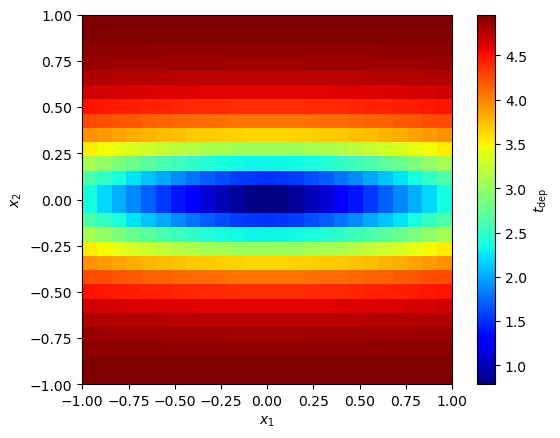

In [7]:
disk1.set_t_dep(q=0.2,
                alpha=3.,
                t_dep_in=0.5,
                t_dep_out=5.)
disk1.set_p_z_tx()
cube.imshow(disk1.t_dep, cmap=plt.cm.jet, colorbar_label='$t_\mathrm{dep}$')

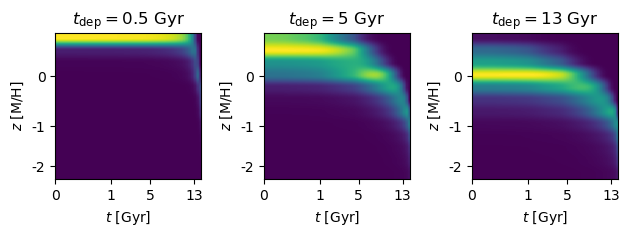

In [14]:
fig, ax = plt.subplots(1, 3)

dummy = pkm.components.parametric.ParametricComponent(cube=cube)

for (t_dep, ax0) in zip([0.5, 5, 13], ax):
    a = dummy.evaluate_chemical_enrichment_model_single_t_dep(t_dep)
    cube.imshow(a.T, view=['t', 'z'], ax=ax0, colorbar=False)
    ax0.set_title('$t_\\mathrm{dep} = '+str(t_dep)+'$ Gyr')
fig.tight_layout()

### Age- and Space- depentdent kinemtaics

We spcify age-dependant maps of mean velocities and velocity dispersions. For an SSP of a single age, the LOSVD is Gaussian with this mean and dispersion. The combined LOSVD, for all ages, can be non-Gaussian.

The mean maps take the form of rotating disks with three parameters: an axis ratio `q`, the radius `rmax` and value `vmax` of the maximum velocity. Velocity dispersion maps are by power laws stratified on ellipses, parameterised with axis ratio `q`, power law slope `alpha` and inner and outer values. Each parameter is specified with values for (young, old) stars, and is linearly interpolated for intermediate between these values,

In [ ]:
disk1.set_mu_v(q_lims=(0.5, 0.1),
               rmax_lims=(0.5, 1.1),
               vmax_lims=(250., 100.))

disk1.set_sig_v(q_lims=(0.5, 0.1),
                alpha_lims=(1.6, 1.8),
                sig_v_in_lims=(40., 100.),
                sig_v_out_lims=(20., 70.))

# plot age averaged velocity map
cube.imshow(disk1.get_mean('v_x'), cmap=plt.cm.jet)

## Add a second disk

We can add a second compoent. We will make this younger, rounder, and counter-rotating.

In [ ]:
disk2 = pkm.components.GrowingDisk(cube=cube, rotation=0., center=(0,0))
disk2.set_p_t(lmd=5., phi=0.4)
disk2.set_p_x_t(q_lims=(0.3, 0.7),
                rc_lims=(0.5, 0.6),
                alpha_lims=(0.8, 1.2))
disk2.set_t_dep(q=0.4, alpha=2., t_dep_in=2., t_dep_out=9.)
disk2.set_p_z_tx()
disk2.set_mu_v(q_lims=(0.5, 0.5),
               rmax_lims=(0.8, 0.1),
               vmax_lims=(-180., -150.))
disk2.set_sig_v(q_lims=(0.7, 0.5),
                alpha_lims=(1.6, 1.8),
                sig_v_in_lims=(40., 100.),
                sig_v_out_lims=(20., 70.))
                
# plot age averaged velocity map
cube.imshow(disk2.get_mean('v_x'), cmap=plt.cm.jet)

## Add a stream component

In [ ]:
stream = pkm.components.Stream(cube=cube, rotation=0., center=(0.,0))
stream.set_p_t(lmd=15., phi=0.3)
stream.set_p_x_t(
    theta_lims=[-np.pi/3., 0.75*np.pi],
    mu_r_lims=[0.4,0.8],
    sig=0.06)
stream.set_t_dep(t_dep=5.)
stream.set_p_z_tx()
stream.set_mu_v(mu_v_lims=[-80,100])
stream.set_sig_v(sig_v=110.)

# plot mean v map of stream, masked where density is low
mean_v_map = stream.get_mean('v_x')
stream_density = stream.get_p('x')
tmp = mean_v_map
tmp[stream_density < 0.1] = -np.inf
cube.imshow(tmp, cmap=plt.cm.jet)


## Combine the components

Combine the disks and stream to create a mixture model for the galaxy, then evaluate the datacube,

In [ ]:
galaxy = pkm.components.Mixture(
    cube=cube,
    component_list=[disk1, disk2, stream],
    weights=[0.65, 0.25, 0.1])

for cmp in galaxy.component_list:
    cmp.evaluate_ybar()
galaxy.evaluate_ybar()

# plot spectrum in spaxel 5,6
lmd = np.exp(cube.ssps.w)
plt.plot(lmd, galaxy.ybar[:,5,6])
plt.gca().set_xlabel('Wavelength')